# Model Training 
This is the code is the training code for ML-based approach in intrusion detection. It was modified from notebook provided by "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)".

Please also cite:
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 

In [5]:
CHECKPOINT_OUTPUT = "./modelsdoscrossval"

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [4]:
# Read the dataset
df = pd.read_csv('../../datasets/output/train_final.csv', parse_dates=['Timestamp'])

In [5]:
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Old Index', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time', 'ICMP Type', 'ICMP Code'], axis=1)

In [6]:
df['Label'].value_counts()

Label
Benign       484847
Portscan     127232
Slowloris      4565
Name: count, dtype: int64

In [7]:
df['Label'] = df['Label'].map({
    "Slowloris": "Slowloris",
    "Portscan": "Not Slowloris",
    "Benign": "Not Slowloris"
})

In [8]:
df['Label'].value_counts()

Label
Not Slowloris    612079
Slowloris          4565
Name: count, dtype: int64

### Data pre-processing

In [9]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [10]:
df['Label'].value_counts()

Label
0    612079
1      4565
Name: count, dtype: int64

In [11]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

array([0, 1])

In [12]:
df.isnull().any().any()

False

In [13]:
df.isna().any().any()

False

In [14]:
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)

In [15]:
labelencoder.classes_

array(['Not Slowloris', 'Slowloris'], dtype='<U13')

## Cross Validation Preparation

In [16]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

splits = []
for train_index, test_index in skf.split(X, y):
    splits.append((train_index, test_index))

In [17]:
i = 0
for train_index, test_index in splits:
    pd.Series(train_index).to_csv(f"{CHECKPOINT_OUTPUT}/imbalance_train_idx_{i}.csv", index=False)
    pd.Series(test_index).to_csv(f"{CHECKPOINT_OUTPUT}/imbalance_test_idx_{i}.csv", index=False)
    i += 1

## Data Balancing by Proposed TVAE-based Method

In [18]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer

def balance_data_with_tvae(df, X_train, y_train):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    y_train = pd.Series(y_train)

    # Identify the average number of samples per class
    average_samples = y_train.value_counts().mean()

    # Identify minority classes with less than half the average number of samples
    minority_classes = y_train.value_counts()
    minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

    # Prepare an empty DataFrame to collect synthetic data
    synthetic_data = pd.DataFrame()

    y_train.index = X_train.index

    # Generating synthetic samples for each minority class using TVAE
    for cls in minority_classes:
        cls_samples = X_train[y_train == cls]
        num_samples_needed = int(average_samples - len(cls_samples))
        
        # Initialize the TVAE model with detected metadata
        tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
        
        # Fit the TVAE model on the minority class samples
        tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
        
        # Generate synthetic instances to match the average class sample size
        new_samples = tvaegan.sample(num_samples_needed)
        
        # Append the new synthetic instances to the synthetic data list
        synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)
    
    # Concatenate the original and synthetic data to form a balanced dataset
    balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

    # Display the new distribution of labels in the balanced dataset
    print(balanced_data['Label'].value_counts())

    # Prepare the balanced dataset for model training
    return (balanced_data.drop(['Label'], axis=1), balanced_data['Label'])

In [19]:
X_train_full_balanced, y_train_full_balanced = balance_data_with_tvae(df, X, y)
X_train_full_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/X_train_full_balanced.pkl")
y_train_full_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/y_train_full_balanced.pkl")

Loss: -396.133: 100%|██████████| 300/300 [01:27<00:00,  3.44it/s]


Label
0    612079
1    308322
Name: count, dtype: int64


In [20]:
balanced_splits = []
i = 0
for train_idx, _ in splits:
    X_train_balanced, y_train_balanced = balance_data_with_tvae(df, X.iloc[train_idx], y[train_idx])
    X_train_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/X_train_balanced_{i}.pkl")
    y_train_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/y_train_balanced_{i}.pkl")
    balanced_splits.append((X_train_balanced, y_train_balanced))
    i += 1

Loss: -450.596: 100%|██████████| 300/300 [01:03<00:00,  4.71it/s]


Label
0    408052
1    205548
Name: count, dtype: int64


Loss: -429.364: 100%|██████████| 300/300 [01:02<00:00,  4.76it/s]


Label
0    408053
1    205548
Name: count, dtype: int64


Loss: -488.102: 100%|██████████| 300/300 [01:03<00:00,  4.72it/s]


Label
0    408053
1    205548
Name: count, dtype: int64


In [21]:
for train_index, test_index in splits:
    print(pd.Series(y[train_index]).value_counts(dropna=False))
    print(pd.Series(y[test_index]).value_counts(dropna=False))

0    408052
1      3044
Name: count, dtype: int64
0    204027
1      1521
Name: count, dtype: int64
0    408053
1      3043
Name: count, dtype: int64
0    204026
1      1522
Name: count, dtype: int64
0    408053
1      3043
Name: count, dtype: int64
0    204026
1      1522
Name: count, dtype: int64


In [22]:
for i in range(3):
    test_idx = splits[i][1]
    X.iloc[test_idx].to_pickle(f"{CHECKPOINT_OUTPUT}/X_validation_{i}.pkl")
    pd.Series(y[test_idx]).to_pickle(f"{CHECKPOINT_OUTPUT}/y_validation_{i}.pkl")

## Checkpoint

In [6]:
X_train_full_balanced = pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_train_full_balanced.pkl")
y_train_full_balanced = pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_train_full_balanced.pkl")

In [7]:
balanced_train_splits = []
for i in range(3):
    balanced_train_splits.append((pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_train_balanced_{i}.pkl"), pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_train_balanced_{i}.pkl")))

In [8]:
val_splits = []
for i in range(3):
    val_splits.append((pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_validation_{i}.pkl"), pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_validation_{i}.pkl")))

## Machine learning model training (for feature selection)

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


In [13]:
import joblib
MODEL_OUTPUT_PREFS = "./models/prefs"

In [7]:
from sklearn.metrics import f1_score

def cross_val_f1_macro(clf):
    results = []
    for i in range(3):
        X_train_balanced, y_train_balanced = balanced_train_splits[i]
        X_val, y_val = val_splits[i]
        clf.fit(X_train_balanced, y_train_balanced)
        y_pred = clf.predict(X_val)
        results.append(f1_score(y_val, y_pred, average='macro'))
    return results

#### DT

In [8]:
import time
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_macro(dt)

start = time.time()
dt.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

Training time:  30.22372341156006
Cross-Validation scores:  [0.9965327729520839, 0.9973591622921759, 0.9975217968716381]
Mean of Cross-Validation scores:  0.9971379107052994


In [14]:
joblib.dump(dt, f"{MODEL_OUTPUT_PREFS}/dt.pkl")

['./models/prefs/dt.pkl']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### RF

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_jobs=12)
rf_scores = cross_val_f1_macro(rf)

start = time.time()
rf.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

Training time:  46.435137033462524


In [11]:
# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

Cross-Validation scores:  [0.9993372039750994, 0.9996690342202528, 0.9995037131514748]
Mean of Cross-Validation scores:  0.999503317115609


In [ ]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [15]:
joblib.dump(rf, f"{MODEL_OUTPUT_PREFS}/rf.pkl")

['./models/prefs/rf.pkl']

#### ET

In [16]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=12)
et_scores = cross_val_f1_macro(et)

# calculate the training time
start = time.time()
et.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

Training time:  22.42880129814148
Cross-Validation scores:  [0.9991723156715354, 0.9995037131514748, 0.999834463134307]
Mean of Cross-Validation scores:  0.9995034973191057


In [ ]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')

y_true = y_val

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [17]:
joblib.dump(et, f"{MODEL_OUTPUT_PREFS}/et.pkl")

['./models/prefs/et.pkl']

#### XGBoost

In [18]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=12)
xg_scores = cross_val_f1_macro(xg)

# calculate the training time
start = time.time()
xg.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

Training time:  3.1633167266845703
Cross-Validation scores:  [0.999337636491995, 0.9995037131514748, 0.9995037131514748]
Mean of Cross-Validation scores:  0.9994483542649816


In [19]:
joblib.dump(xg, f"{MODEL_OUTPUT_PREFS}/xg.pkl")

['./models/prefs/xg.pkl']

In [ ]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### LightGBM

In [20]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_f1_macro(lgbm)

# calculate the training time
start = time.time()
lgbm.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16266
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 408053
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

In [21]:
joblib.dump(lgbm, f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")

['./models/prefs/lgbm.pkl']

In [ ]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Catboost

In [22]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, thread_count=12)
cat_scores = cross_val_f1_macro(cat)

# calculate the training time
start = time.time()
cat.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

Training time:  43.19799256324768
Cross-Validation scores:  [0.9986735417773922, 0.9990071026607582, 0.9988427517749954]
Mean of Cross-Validation scores:  0.9988411320710485


In [23]:
joblib.dump(cat, f"{MODEL_OUTPUT_PREFS}/cat.pkl")

['./models/prefs/cat.pkl']

In [ ]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='macro')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [24]:
import gc
gc.collect()

0

## Model selection

In [31]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)
}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [62]:
base_model_performance

{'dt': 0.9971379107052994,
 'rf': 0.999503317115609,
 'et': 0.9995034973191057,
 'xg': 0.9994483542649816,
 'lgbm': 0.9995035692632287,
 'cat': 0.9988411320710485}

In [63]:
ranked_models

['lgbm', 'et', 'rf', 'xg', 'cat', 'dt']

In [32]:
top_3_models

['lgbm', 'et', 'rf']

## Automated Feature Selection

In [34]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [35]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [38]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature = X_train_full_balanced.columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.0722, 'Fwd Seg Size Min'), (0.038, 'Bwd Packet Length Mean'), (0.037, 'FWD Init Win Bytes'), (0.0363, 'Fwd IAT Max'), (0.0355, 'Bwd RST Flags'), (0.0349, 'Bwd Packet Length Max'), (0.0341, 'FIN Flag Count'), (0.0332, 'Fwd IAT Min'), (0.0287, 'Protocol'), (0.0263, 'Bwd Segment Size Avg'), (0.025, 'Flow IAT Mean'), (0.0221, 'Fwd Packet Length Max'), (0.0212, 'Down/Up Ratio'), (0.0198, 'Flow IAT Min'), (0.0187, 'RST Flag Count'), (0.0187, 'Flow Duration'), (0.0186, 'Subflow Fwd Packets'), (0.0181, 'Flow IAT Max'), (0.018, 'Flow Packets/s'), (0.0172, 'Active Min'), (0.017, 'Bwd IAT Min'), (0.0165, 'Bwd Act Data Pkts'), (0.0164, 'Bwd Init Win Bytes'), (0.0163, 'Bwd IAT Max'), (0.0152, 'SYN Flag Count'), (0.015, 'Idle Max'), (0.0144, 'Fwd IAT Total'), (0.0136, 'Total Length of Bwd Packet'), (0.0135, 'Fwd IAT Mean'), (0.0134, 'Fwd Packets/s'), (0.0125, 'Average Packet Size'), (0.0122, 'Bwd IAT Mean'), (0.0121, 'Total Bwd packets'), (0.0112, 'Bwd Packets/s')

In [39]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [40]:
print(fs)

['Fwd Seg Size Min', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Bwd RST Flags', 'Bwd Packet Length Max', 'FIN Flag Count', 'Fwd IAT Min', 'Protocol', 'Bwd Segment Size Avg', 'Flow IAT Mean', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow IAT Min', 'RST Flag Count', 'Flow Duration', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Active Min', 'Bwd IAT Min', 'Bwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd IAT Max', 'SYN Flag Count', 'Idle Max', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Fwd IAT Mean', 'Fwd Packets/s', 'Average Packet Size', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd Packets/s', 'Bwd IAT Total', 'Packet Length Mean', 'Packet Length Max', 'Bwd PSH Flags', 'Flow IAT Std', 'Packet Length Std', 'Fwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd IAT Std', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Fwd Bytes/Bulk Avg', 'ACK Flag Count', 'Packet Length Variance']


In [9]:
fs = ['Fwd Seg Size Min', 'Bwd Packet Length Mean', 'FWD Init Win Bytes', 'Fwd IAT Max', 'Bwd RST Flags', 'Bwd Packet Length Max', 'FIN Flag Count', 'Fwd IAT Min', 'Protocol', 'Bwd Segment Size Avg', 'Flow IAT Mean', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow IAT Min', 'RST Flag Count', 'Flow Duration', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Active Min', 'Bwd IAT Min', 'Bwd Act Data Pkts', 'Bwd Init Win Bytes', 'Bwd IAT Max', 'SYN Flag Count', 'Idle Max', 'Fwd IAT Total', 'Total Length of Bwd Packet', 'Fwd IAT Mean', 'Fwd Packets/s', 'Average Packet Size', 'Bwd IAT Mean', 'Total Bwd packets', 'Bwd Packets/s', 'Bwd IAT Total', 'Packet Length Mean', 'Packet Length Max', 'Bwd PSH Flags', 'Flow IAT Std', 'Packet Length Std', 'Fwd Bulk Rate Avg', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd IAT Std', 'Fwd Packet Length Std', 'Flow Bytes/s', 'Fwd Bytes/Bulk Avg', 'ACK Flag Count', 'Packet Length Variance']

In [1]:
pairs = [(0.0722, 'Fwd Seg Size Min'), (0.038, 'Bwd Packet Length Mean'), (0.037, 'FWD Init Win Bytes'), (0.0363, 'Fwd IAT Max'), (0.0355, 'Bwd RST Flags'), (0.0349, 'Bwd Packet Length Max'), (0.0341, 'FIN Flag Count'), (0.0332, 'Fwd IAT Min'), (0.0287, 'Protocol'), (0.0263, 'Bwd Segment Size Avg'), (0.025, 'Flow IAT Mean'), (0.0221, 'Fwd Packet Length Max'), (0.0212, 'Down/Up Ratio'), (0.0198, 'Flow IAT Min'), (0.0187, 'RST Flag Count'), (0.0187, 'Flow Duration'), (0.0186, 'Subflow Fwd Packets'), (0.0181, 'Flow IAT Max'), (0.018, 'Flow Packets/s'), (0.0172, 'Active Min'), (0.017, 'Bwd IAT Min'), (0.0165, 'Bwd Act Data Pkts'), (0.0164, 'Bwd Init Win Bytes'), (0.0163, 'Bwd IAT Max'), (0.0152, 'SYN Flag Count'), (0.015, 'Idle Max'), (0.0144, 'Fwd IAT Total'), (0.0136, 'Total Length of Bwd Packet'), (0.0135, 'Fwd IAT Mean'), (0.0134, 'Fwd Packets/s'), (0.0125, 'Average Packet Size'), (0.0122, 'Bwd IAT Mean'), (0.0121, 'Total Bwd packets'), (0.0112, 'Bwd Packets/s'), (0.0109, 'Bwd IAT Total'), (0.0107, 'Packet Length Mean'), (0.0102, 'Packet Length Max'), (0.0101, 'Bwd PSH Flags'), (0.0098, 'Flow IAT Std'), (0.009, 'Packet Length Std'), (0.009, 'Fwd Bulk Rate Avg'), (0.0086, 'Fwd Segment Size Avg'), (0.0085, 'Fwd Packet Length Min'), (0.0084, 'Fwd IAT Std'), (0.0071, 'Fwd Packet Length Std'), (0.0069, 'Flow Bytes/s'), (0.0065, 'Fwd Bytes/Bulk Avg'), (0.0062, 'ACK Flag Count'), (0.0061, 'Packet Length Variance')]

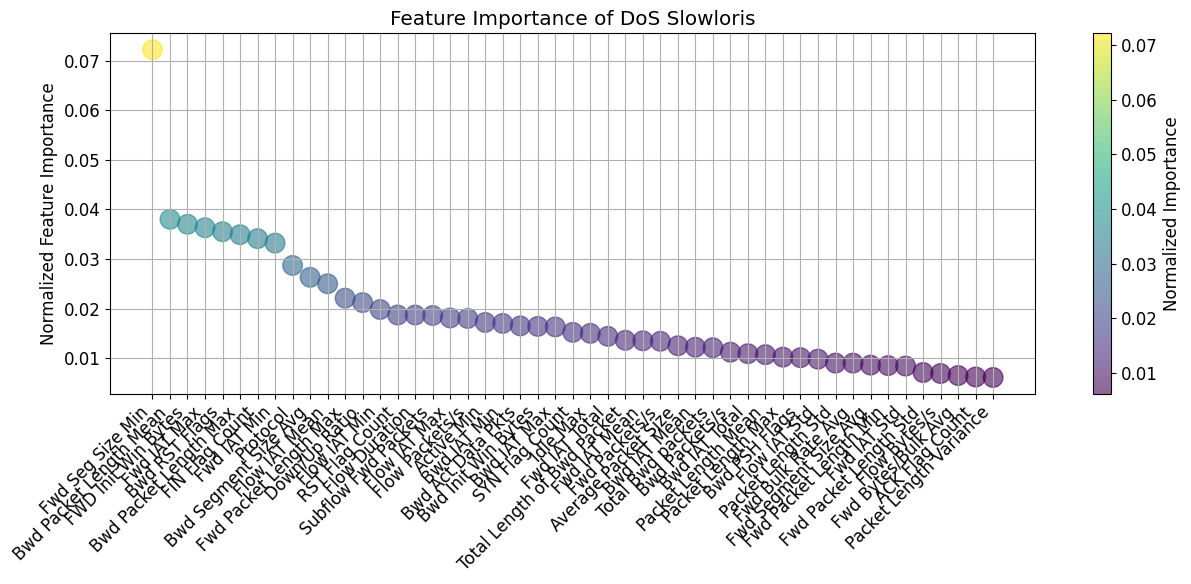

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

features = pd.DataFrame(pairs, columns=['Importance', 'Feature'])

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(13, 6))
scatter = plt.scatter(
    x=features['Feature'],
    y=features['Importance'],
    s=200,
    c=features['Importance'],
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance of DoS Slowloris')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
num_features_original = len(X_train_full_balanced.columns)
num_features_selected = len(fs)

print(f"Features before selection: {num_features_original}")
print(f"Features after selection: {num_features_selected}")

Features before selection: 81
Features after selection: 49


In [10]:
X_train_full_balanced_fs = X_train_full_balanced[fs]

In [11]:
balanced_train_splits_fs = []
val_splits_fs = []
for i in range(3):
    X_train_balanced, y_train_balanced = balanced_train_splits[i]
    X_val, y_val = val_splits[i]
    balanced_train_splits_fs.append((X_train_balanced[fs], y_train_balanced))
    val_splits_fs.append((X_val[fs], y_val))

# Testing

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

In [12]:
POST_FS_MODEL_OUTPUT = "./modelsdossinglethread/postfs"

In [53]:
def cross_val_f1_macro_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]
        clf.fit(X_train_balanced_fs, y_train_balanced_fs)
        y_pred_fs = clf.predict(X_val_fs)
        results.append(f1_score(y_val_fs, y_pred_fs, average='macro'))
    return results

### DT

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_macro_fs(dt)

start = time.time()
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

Training time:  26.638545036315918
Cross-Validation scores:  [0.9963712083300027, 0.9980180826607221, 0.9980154994652513]
Mean of Cross-Validation scores:  0.9974682634853252


In [55]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_untuned.pkl")

['./models/postfs/dt_untuned.pkl']

In [ ]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score, make_scorer
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [11:27<00:00, 34.36s/trial, best loss: -0.9983502262712953]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 5}


DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_split=5,
                       random_state=0)

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 5})
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)

DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_split=5,
                       random_state=0)

In [21]:
import joblib
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_tuned.pkl")

['./modelsdossinglethread/postfs/dt_tuned.pkl']

In [100]:
dt_score = 0.9983502262712953

### RF

In [58]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_f1_macro_fs(rf)

# calculate the training time
start = time.time()
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

Training time:  50.18733048439026
Cross-Validation scores:  [0.999337636491995, 0.9995037131514748, 0.9995037131514748]
Mean of Cross-Validation scores:  0.9994483542649816


In [59]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./models/postfs/rf_untuned.pkl']

In [ ]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 150, 5),
    'max_depth': hp.quniform('max_depth', 5, 40, 3),
    "max_features":hp.quniform('max_features', 1, 7, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [17:51<00:00, 53.58s/trial, best loss: -0.9995034612879076]
Random Forest: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 115}


RandomForestClassifier(criterion='entropy', max_depth=30, max_features=4,
                       min_samples_split=5, n_estimators=115, random_state=0)

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, n_jobs=1, **{'criterion': 'entropy', 'max_depth': 30, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 115})
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)

RandomForestClassifier(criterion='entropy', max_depth=30, max_features=4,
                       min_samples_split=5, n_estimators=115, n_jobs=1,
                       random_state=0)

In [22]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_tuned.pkl")

['./modelsdossinglethread/postfs/rf_tuned.pkl']

In [101]:
rf_score = 0.9995034612879076

In [102]:
import gc
gc.collect()

4346

### ET

In [67]:
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=12)
et_scores = cross_val_f1_macro_fs(et)

# calculate the training time
start = time.time()
et.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

Training time:  18.059419631958008
Cross-Validation scores:  [0.9991723156715354, 0.9995037131514748, 0.999834463134307]
Mean of Cross-Validation scores:  0.9995034973191057


In [68]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./models/postfs/et_untuned.pkl']

In [ ]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [14:15<00:00, 42.80s/trial, best loss: -0.999613747171427]
Extra Trees: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 35, 'max_features': 17, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 95}


ExtraTreesClassifier(max_depth=35, max_features=17, min_samples_leaf=2,
                     min_samples_split=6, n_estimators=95, random_state=0)

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, n_jobs=1, **{'criterion': 'gini', 'max_depth': 35, 'max_features': 17, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 95})
et.fit(X_train_full_balanced_fs, y_train_full_balanced)

ExtraTreesClassifier(max_depth=35, max_features=17, min_samples_leaf=2,
                     min_samples_split=6, n_estimators=95, n_jobs=1,
                     random_state=0)

In [103]:
et_score = 0.999613747171427 # from printed best loss above

In [24]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_tuned.pkl")

['./modelsdossinglethread/postfs/et_tuned.pkl']

In [71]:
import gc
gc.collect()

28

### XGBoost

In [72]:
import xgboost as xgb
import numpy as np

# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=12)
xg_scores = cross_val_f1_macro_fs(xg)

# calculate the training time
start = time.time()
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

Training time:  2.081331491470337
Cross-Validation scores:  [0.9995030652284991, 0.9996690342202528, 0.9995037131514748]
Mean of Cross-Validation scores:  0.9995586042000756


In [73]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./models/postfs/xg_untuned.pkl']

In [ ]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(eval_metric='mlogloss', random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 150, 3),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1),
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [01:51<00:00,  5.57s/trial, best loss: -0.9996688541943529]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.6508227343810686, 'max_depth': 4, 'n_estimators': 108}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.6508227343810686, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=108, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [25]:
import xgboost as xgb

# Use the best parameters to train the model
xg = xgb.XGBClassifier(eval_metric='mlogloss', random_state=0, n_jobs=1, **{'learning_rate': 0.6508227343810686, 'max_depth': 4, 'n_estimators': 108})
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.6508227343810686, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=108, n_jobs=1,
              num_parallel_tree=None, random_state=0, ...)

In [105]:
xg_score = 0.9996688541943529

In [26]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_tuned.pkl")

['./modelsdossinglethread/postfs/xg_tuned.pkl']

### LightGBM

In [76]:
import lightgbm as lgb
import numpy as np

# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=12)
lgbm_scores = cross_val_f1_macro_fs(lgbm)

# calculate the training time
start = time.time()
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10689
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 408053
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

In [77]:
import joblib
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./models/postfs/lgbm_untuned.pkl']

In [ ]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10689                    
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

LGBMClassifier(learning_rate=0.1521170276706296, max_depth=6,
               min_child_samples=12, n_estimators=84, num_leaves=21,
               random_state=0)

In [18]:
import lightgbm as lgb

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=1, **{'learning_rate': 0.1521170276706296, 'max_depth': 6, 'min_child_samples': 12, 'n_estimators': 84, 'num_leaves': 21})
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 308322, number of negative: 612079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10702
[LightGBM] [Info] Number of data points in the train set: 920401, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685717
[LightGBM] [Info] Start training from score -0.685717


LGBMClassifier(learning_rate=0.1521170276706296, max_depth=6,
               min_child_samples=12, n_estimators=84, n_jobs=1, num_leaves=21,
               random_state=0)

In [20]:
import joblib
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned.pkl")

['./modelsdossinglethread/postfs/lgbm_tuned.pkl']

In [106]:
lgbm_score = 0.999558604259259

### CatBoost

In [80]:
from catboost import CatBoostClassifier
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, verbose=False)
cat_scores = cross_val_f1_macro_fs(cat)

# calculate the training time
start = time.time()
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

Training time:  40.07325839996338
Cross-Validation scores:  [0.9983440912299876, 0.9990077497326257, 0.9993380684405055]
Mean of Cross-Validation scores:  0.9988966364677063


In [81]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./models/postfs/cat_untuned.pkl']

In [ ]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=12, **params)
    score = np.mean(cross_val_f1_macro_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [29:15<00:00, 87.76s/trial, best loss: -0.9990623894258115]  
CatBoost: Hyperopt estimated optimum {'depth': 7, 'iterations': 900, 'learning_rate': 0.1364116455094896}


In [27]:
import catboost as cb

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=1, **{'depth': 7, 'iterations': 900, 'learning_rate': 0.1364116455094896})
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)

In [107]:
cat_score = 0.9990623894258115

In [28]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_tuned.pkl")

['./modelsdossinglethread/postfs/cat_tuned.pkl']

## Model selection

In [108]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': dt_score,
    'rf': rf_score,
    'et': et_score,
    'xg': xg_score,
    'lgbm': lgbm_score,
    'cat': cat_score,

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [109]:
base_model_performance

{'dt': 0.9983502262712953,
 'rf': 0.9995034612879076,
 'et': 0.999613747171427,
 'xg': 0.9996688541943529,
 'lgbm': 0.999558604259259,
 'cat': 0.9990623894258115}

In [110]:
ranked_models

['xg', 'et', 'lgbm', 'rf', 'cat', 'dt']

In [111]:
top_3_models

['xg', 'et', 'lgbm']

In [29]:
def transform_stk1(x_val_stk):
    y_model_1 = xg.predict(x_val_stk).reshape(-1, 1)
    y_model_2 = et.predict(x_val_stk).reshape(-1, 1)
    y_model_3 = lgbm.predict(x_val_stk).reshape(-1, 1)
    return np.concatenate([y_model_1, y_model_2, y_model_3], axis=1)

def transform_stk2(x_val_stk):
    y_proba_1 = xg.predict_proba(x_val_stk)
    y_proba_2 = et.predict_proba(x_val_stk)
    y_proba_3 = lgbm.predict_proba(x_val_stk)
    return np.concatenate([y_proba_1, y_proba_2, y_proba_3], axis=1)

def transform_stk3(x_val_stk):
    y_model_1 = xg.predict(x_val_stk).reshape(-1, 1)
    y_model_2 = et.predict(x_val_stk).reshape(-1, 1)
    y_model_3 = lgbm.predict(x_val_stk).reshape(-1, 1)
    y_proba_1 = xg.predict_proba(x_val_stk)
    y_proba_2 = et.predict_proba(x_val_stk)
    y_proba_3 = lgbm.predict_proba(x_val_stk)
    return np.concatenate([y_model_1, y_model_2, y_model_3] + [y_proba_1, y_proba_2, y_proba_3], axis=1)

In [143]:
def cross_val_f1_macro_stk1_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]

        x_train_tf = transform_stk1(X_train_balanced_fs)
        x_val_tf = transform_stk1(X_val_fs)

        clf.fit(x_train_tf, y_train_balanced_fs)
        y_pred_fs = clf.predict(x_val_tf)
        results.append(f1_score(y_val_fs, y_pred_fs, average='macro'))
    return results

def cross_val_f1_macro_stk2_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]

        x_train_tf = transform_stk2(X_train_balanced_fs)
        x_val_tf = transform_stk2(X_val_fs)

        clf.fit(x_train_tf, y_train_balanced_fs)
        y_pred_fs = clf.predict(x_val_tf)
        results.append(f1_score(y_val_fs, y_pred_fs, average='macro'))
    return results

def cross_val_f1_macro_stk3_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]

        x_train_tf = transform_stk3(X_train_balanced_fs)
        x_val_tf = transform_stk3(X_val_fs)

        clf.fit(x_train_tf, y_train_balanced_fs)
        y_pred_fs = clf.predict(x_val_tf)
        results.append(f1_score(y_val_fs, y_pred_fs, average='macro'))
    return results

In [144]:
# Ensemble method 1: traditional stacking

stk1 = lgb.LGBMClassifier(random_state=0)
stk1_scores = cross_val_f1_macro_stk1_fs(stk1)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', stk1_scores)
print('Mean of Cross-Validation scores: ', np.mean(stk1_scores))

x_stk1 = transform_stk1(X_train_full_balanced_fs)
stk1.fit(x_stk1, y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(random_state=0)

In [145]:
joblib.dump(stk1, f"{POST_FS_MODEL_OUTPUT}/stk1_untuned.pkl")

['./models/postfs/stk1_untuned.pkl']

In [148]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_stk1_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk1 = lgb.LGBMClassifier(random_state=0, **best)
stk1.fit(transform_stk1(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6                        
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.9294052974924978, max_depth=54,
               min_child_samples=66, n_estimators=84, num_leaves=24,
               random_state=0)

In [149]:
joblib.dump(stk1, f"{POST_FS_MODEL_OUTPUT}/stk1_tuned.pkl")

['./models/postfs/stk1_tuned.pkl']

In [150]:
# Ensemble method 2: confidence-based stacking

stk2 = lgb.LGBMClassifier(random_state=0)
stk2_scores = cross_val_f1_macro_stk2_fs(stk2)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', stk2_scores)
print('Mean of Cross-Validation scores: ', np.mean(stk2_scores))

x_stk2 = transform_stk2(X_train_full_balanced_fs)
stk2.fit(x_stk2, y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=0)

In [151]:
joblib.dump(stk2, f"{POST_FS_MODEL_OUTPUT}/stk2_untuned.pkl")

['./models/postfs/stk2_untuned.pkl']

In [152]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_stk2_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk2 = lgb.LGBMClassifier(random_state=0, **best)
stk2.fit(transform_stk2(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1232                     
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.027666796578952803, max_depth=45,
               min_child_samples=63, n_estimators=36, num_leaves=36,
               random_state=0)

In [153]:
joblib.dump(stk2, f"{POST_FS_MODEL_OUTPUT}/stk2_tuned.pkl")

['./models/postfs/stk2_tuned.pkl']

In [154]:
# Ensemble method 3: hybrid stacking

stk3 = lgb.LGBMClassifier(random_state=0)
stk3_scores = cross_val_f1_macro_stk3_fs(stk3)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', stk3_scores)
print('Mean of Cross-Validation scores: ', np.mean(stk3_scores))

x_stk3 = transform_stk3(X_train_full_balanced_fs)
stk3.fit(x_stk3, y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=0)

In [155]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/stk3_untuned.pkl")

['./models/postfs/stk3_untuned.pkl']

In [ ]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_macro_stk3_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

[LightGBM] [Info] Number of positive: 205548, number of negative: 408052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238                     
[LightGBM] [Info] Number of data points in the train set: 613600, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685715
[LightGBM] [Info] Start training from score -0.685715 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.012752634632813464, max_depth=36,
               min_child_samples=15, n_estimators=36, num_leaves=33,
               random_state=0)

In [30]:
# Use the best parameters to train the model
stk3 = lgb.LGBMClassifier(random_state=0, **{'learning_rate': 0.012752634632813464, 'max_depth': 36, 'min_child_samples': 15, 'n_estimators': 36, 'num_leaves': 33})
stk3.fit(transform_stk3(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 308322, number of negative: 612079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 920401, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334987 -> initscore=-0.685717
[LightGBM] [Info] Start training from score -0.685717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(learning_rate=0.012752634632813464, max_depth=36,
               min_child_samples=15, n_estimators=36, num_leaves=33,
               random_state=0)

In [31]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/stk3_tuned.pkl")

['./modelsdossinglethread/postfs/stk3_tuned.pkl']